In [3]:
%matplotlib inline

# Transfer Learning Tutorial
We will see now how it's possible to use transfer learning in PyTorch.
This is a modified bersion Author: Robert Guthrie.


In [ ]:
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.optim as optim
from torchvision import models
from torchvision import transforms
import copy
import os
from os import listdir
import shutil
from torchvision import datasets
import random
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt

In [4]:
# # Create train and test dataset

data_dir = os.path.join('kagglecatsanddogs_3367a','PetImages')

# # Create the train and test set folder
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validation')
train_dir_cat = os.path.join(train_dir,'Cat')
train_dir_dog = os.path.join(train_dir,'Dog') 
validation_dir_cat = os.path.join(validation_dir,'Cat')
validation_dir_dog = os.path.join(validation_dir,'Dog') 

try:
    os.mkdir(train_dir)
    os.mkdir(train_dir_dog)
    os.mkdir(train_dir_cat)
    os.mkdir(validation_dir)
    os.mkdir(validation_dir_dog)
    os.mkdir(validation_dir_cat)
except FileExistsError:
    print('File exists')

dir_cat = os.path.join(data_dir,'Cat')
dir_dog = os.path.join(data_dir,'Dog')

files_cat = [os.path.join(dir_cat, f) for f in os.listdir(dir_cat) if os.path.isfile(os.path.join(dir_cat, f))]
files_dog = [os.path.join(dir_dog, f) for f in os.listdir(dir_dog) if os.path.isfile(os.path.join(dir_dog, f))]

msk_cat = np.random.rand(len(files_cat)) < 0.8
msk_dog = np.random.rand(len(files_dog)) < 0.8

rand_items_cats = random.sample(files_cat, int(len(files_cat)*0.8))
rand_items_dogs = random.sample(files_dog, int(len(files_dog)*0.8))


# # validation_data
# # train_data


def move_file_list(directory, file_list):
    for f in file_list:
        f_name = f.split('/')[-1]
        shutil.move(f, os.path.join(directory, f_name))

move_file_list(train_dir_dog, rand_items_dogs)
move_file_list(train_dir_dog, rand_items_dogs)

files_cat_v = [os.path.join(dir_cat, f) for f in os.listdir(dir_cat) if os.path.isfile(os.path.join(dir_cat, f))]
files_dog_v = [os.path.join(dir_dog, f) for f in os.listdir(dir_dog) if os.path.isfile(os.path.join(dir_dog, f))]

move_file_list(validation_dir_cat, files_cat_v)
move_file_list(validation_dir_dog, files_dog_v)


File exists


# Load Data

Download the data from:
https://www.microsoft.com/en-us/download/details.aspx?id=54765

We will use torchvision and torch.utils.data packages for loading the
data.

We will now train a classifier to classify images of cats and dogs. Please make sure you place the images in a directory that reflects the directory in your code.



In [5]:
# Data augmentation and normalization for training
# Just normalization for validation
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'validation']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'validation']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation']}
class_names = image_datasets['train'].classes

device = torch.device("cpu")

Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



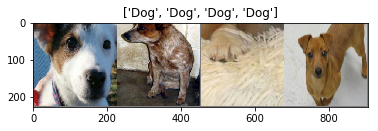

In [67]:

def imshow(input_image, title=None):
    """Plot the input tensor as animage"""
    input_image = input_image.numpy()
    input_image = input_image.transpose((1, 2, 0))
    input_image = std * input_image + mean
    plt.imshow(input_image)
    plt.title(title)

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [18]:
def train_model(model, criterion, optimizer, scheduler, epochs=10):

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(epochs):
        print('Epoch {} of a total of {}'.format(epoch, epochs - 1))

        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    print('Training finish')
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Finetuning the convnet

We will now load a pretrained model and reset final fully connected layer.


In [40]:
model_ft = models.resnet18(pretrained=True)

In [26]:
# To run this cell it's necessary to install torchsummary
# pip install torchsummary
from torchsummary import summary
summary(model_ft, input_size=(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

In [68]:
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft.fc = nn.Sigmoid()
# model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
AC
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=4, gamma=0.1)

# Feature extraction

In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

# Train and testing

We will now see the performance of our algpriyhm.

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=1)

Epoch 0/0
----------


In [ ]:
model_ft.fc = nn.Linear(num_fetures, 2)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=4, gamma=0.1)
And now we can finally train it:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, dataloader_training=dataloaders_train, 
                       Sdataloader_validation=dataloaders_validation, epochs=1)
